In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt


# Custom Imports for this example
from PIL import Image
from particleloader import load
from particleloader.utils import center_and_normalize_zyphi
from rikabplotlib.plot_utils import  newplot, plot_event, hist_with_outline



from pyspecter.SPECTER import SPECTER




1.0000000000000002
(1, 150, 3)
[0.00644245 0.00644245 0.00644245 0.00644245 0.00644245 0.00646875
 0.00646875 0.00649504 0.00649504 0.00649504 0.00649504 0.00649504
 0.00649504 0.00652134 0.00652134 0.00652134 0.00652134 0.00657393
 0.00657393 0.00660023 0.00660023 0.00660023 0.00660023 0.00662652
 0.00662652 0.00662652 0.00662652 0.00662652 0.00662652 0.00662652
 0.00662652 0.00662652 0.00662652 0.00662652 0.00662652 0.00662652
 0.00665282 0.00665282 0.00665282 0.00667911 0.00667911 0.00667911
 0.00667911 0.00667911 0.00667911 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541 0.00670541
 0.00670541 0.00670541 0.006705

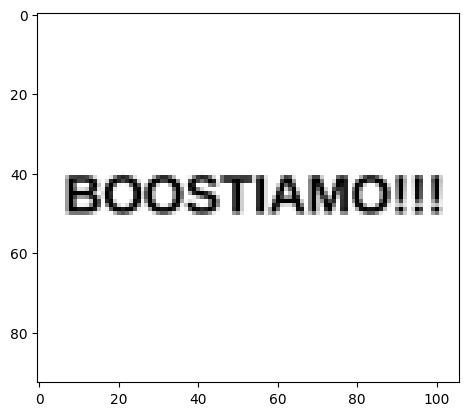

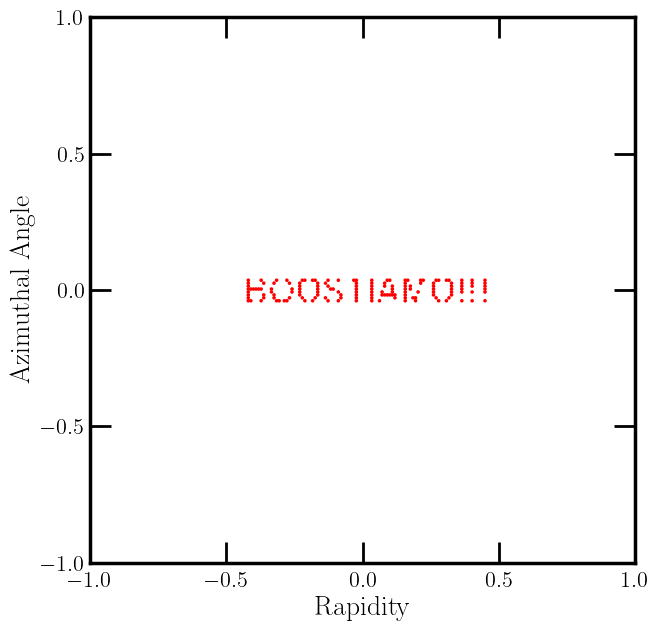

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [3]:

# Parameters
R = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"
cache_dir = "~/.ParticleLoader"

image_loc = "boostiamo.png"


def convert_image_to_array(image_path, N = 100):
    # Load the image
    with Image.open(image_path) as img:
        # Calculate the aspect ratio
        original_width, original_height = img.size
        aspect_ratio = original_width / original_height

        # Calculate new dimensions for downsampling
        # The target is to have at most 625 pixels
        max_pixels = 10000
        new_height = int((max_pixels / aspect_ratio) ** 0.5)
        new_width = int(aspect_ratio * new_height)

        # Resize the image
        resized_img = img.resize((new_width, new_height))

        # Convert image to greyscale
        grey_img = resized_img.convert('L')

        # display the image
        plt.imshow(grey_img, cmap='gray')

        # Initialize array
        pixel_array = []

        # Iterate over each pixel in the resized image
        for y in range(new_height):
            for x in range(new_width):
                # Get pixel value (0 to 255)
                pixel_value = grey_img.getpixel((x, y))

                # Normalize intensity (1 for black, 0 for white)
                intensity = 1 - (pixel_value / 255)

                # Normalize x and y coordinates
                norm_x = x / new_width
                norm_y = y / new_height

                # Append to array
                pixel_array.append([intensity, norm_x, norm_y])

        # Sort the list by intensity
        pixel_array = sorted(pixel_array, key=lambda x: x[0], reverse=True)

        # Keep only the top N pixels
        pixel_array = pixel_array[:N]

        # Normalize intensities to sum to 1
        pixel_array = np.array(pixel_array)
        pixel_array[:,0] = pixel_array[:,0] / np.sum(pixel_array[:,0])

        # Center by subtracting mean x and y
        pixel_array[:,1] = pixel_array[:,1] - np.mean(pixel_array[:,1])
        pixel_array[:,2] = pixel_array[:,2] - np.mean(pixel_array[:,2])

        # flip y
        pixel_array[:,2] = -pixel_array[:,2]

        return pixel_array

image1 = convert_image_to_array(image_loc, N = 150)

print(image1[:,0].sum())

# Remove all pixels with intensity 0
# image1 = image1[image1[:,0] > 0.002]

# Add extra dimension for batch in the front
image1 = np.expand_dims(image1, axis=0)

# print(image1)
print(image1.shape)

print(np.sort(image1[0,:,0]))


fig, ax = newplot("full")

plot_event(ax, image1[0], R, color = "red")
# plot_event(image2[0,:,1:], image2[0,:,0], R, color = "blue")


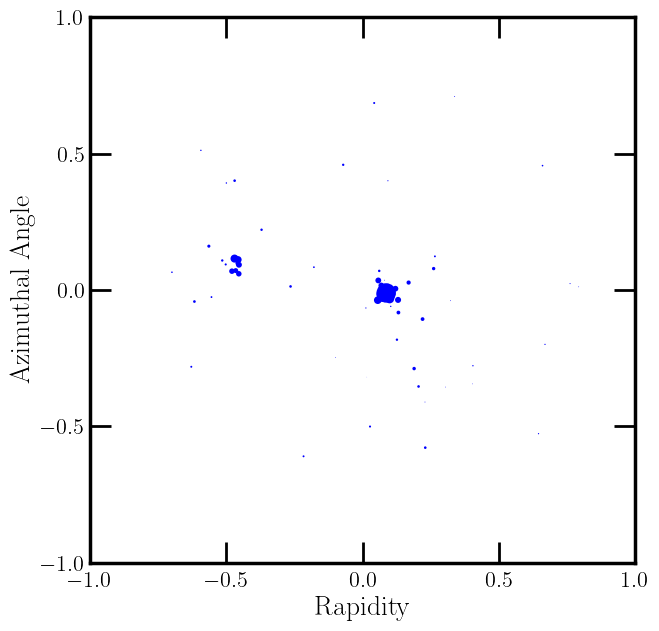

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [5]:


qcd = load("SPECTER_qcd_jets", num_samples= 1000, cache_dir=cache_dir)
qcd = center_and_normalize_zyphi(qcd)




fig, ax = newplot("full")
plot_event(ax, qcd[0], R, color = "blue")

In [9]:
specter = SPECTER(compile = True)

Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  9.34023404121399  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  74.57333946228027  seconds.
Compilation complete! Time taken:  74.57335686683655  seconds.


In [10]:
# Compute the SEMD
from tqdm import tqdm

SEMDs = []
for event in tqdm(qcd):

    bee = np.expand_dims(event, axis=0)

    specter_emds = specter.spectralEMD(bee, image1)
    SEMDs.append(specter_emds[0]) 

100%|██████████| 1000/1000 [00:44<00:00, 22.30it/s]


[[ 1.82958553e-03 -7.10049987e-01 -2.32586384e-01]
 [ 2.65868235e-04  6.67641044e-01  1.08383417e-01]
 [ 1.99376885e-03 -2.58011729e-01 -5.82046032e-01]
 [ 4.21651348e-05 -2.77947575e-01 -5.47166348e-01]
 [ 2.25869427e-03  2.77501047e-01 -4.82645988e-01]
 [ 2.18464455e-04 -4.23292965e-01 -3.56966019e-01]
 [ 5.39059192e-03 -4.48053956e-01 -1.95415974e-01]
 [ 3.87439592e-04 -4.94802952e-01 -1.19606018e-01]
 [ 8.84945621e-04  3.15585017e-01  3.58564138e-01]
 [ 4.59772273e-04  5.07597029e-01  1.29093409e-01]
 [ 4.32460511e-04  2.83039033e-01  3.00674200e-01]
 [ 7.77797075e-03  2.57475019e-01  2.98795938e-01]
 [ 5.27088530e-04  2.51497030e-01  3.02798033e-01]
 [ 6.78257318e-03  3.78418028e-01  1.05753660e-01]
 [ 6.97348616e-04  3.97296011e-01  1.01773500e-01]
 [ 4.92281979e-04 -2.91889459e-01 -1.88346386e-01]
 [ 6.38522208e-04 -1.92653477e-01  2.84947157e-01]
 [ 2.61891750e-03 -2.24254563e-01 -2.09976196e-01]
 [ 7.65416771e-04  2.87383020e-01  5.19034751e-02]
 [ 2.16498645e-03  2.53015041e-

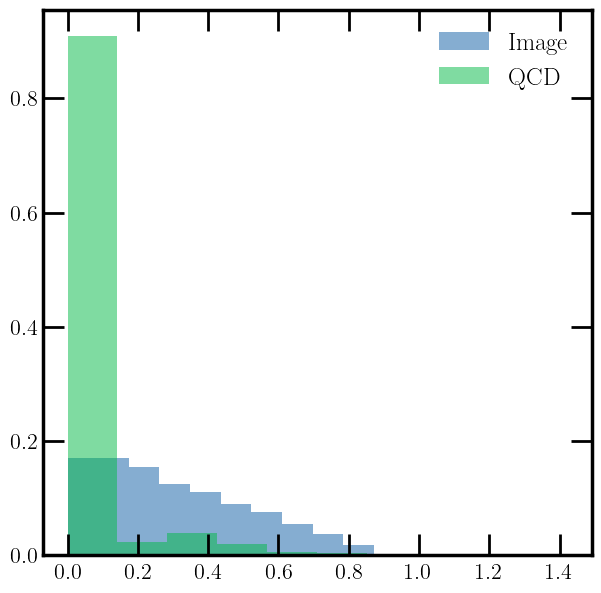

In [11]:
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

s1 = compute_spectral_representation(image1[0])
s2 = compute_spectral_representation(event)

print(event)

print(s1)
print(s2)

fig, ax = newplot("full")
ax.hist(s1[:,0], weights = s1[:,1], label = "Image", alpha = 0.5)
ax.hist(s2[:,0], weights = s2[:,1], label = "QCD", alpha = 0.5)
ax.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Array(0.02082424, dtype=float32), Array(0.01042084, dtype=float32), Array(0.05319916, dtype=float32), Array(0.1016674, dtype=float32), Array(0.01035416, dtype=float32), Array(0.08548445, dtype=float32), Array(0.09813637, dtype=float32), Array(0.00463626, dtype=float32), Array(0.01133358, dtype=float32), Array(0.10411101, dtype=float32), Array(0.04156519, dtype=float32), Array(0.07258059, dtype=float32), Array(0.0117718, dtype=float32), Array(0.05100963, dtype=float32), Array(0.07891711, dtype=float32), Array(0.03247771, dtype=float32), Array(0.01438385, dtype=float32), Array(0.07001019, dtype=float32), Array(0.06629166, dtype=float32), Array(0.12201728, dtype=float32), Array(0.08426075, dtype=float32), Array(0.10359499, dtype=float32), Array(0.11339954, dtype=float32), Array(0.0826008, dtype=float32), Array(0.10182112, dtype=float32), Array(0.10918757, dtype=float32), Array(0.11886355, dtype=float32), Array(0.04641513, dtype=float32), Array(0.02078441, dtype=float32), Array(0.10487445

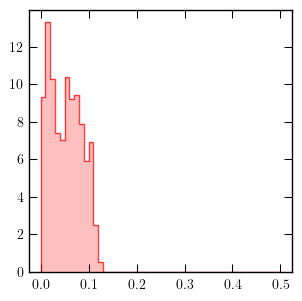

In [12]:
fig, ax = newplot("column")
print(SEMDs)

# plt.hist(SEMDs, bins = 50, color = "blue", label = "QCD")

hist_with_outline(ax, SEMDs , bins = 50, range = [0,0.5], color = "red", density = True)

plt.legend(loc = "upper right")
# plt.xlabel("SEMD")
# plt.ylabel("Density")